With Constant Step Size
MDP with 10 states and 2 actions
discounting factor gamma = 0.95, step size alpha = 0.01

Running  1 episodes

The Policy is (state,action) = probability
(0,0) = 0.4835164835164835  (0,1) = 0.5164835164835165  
(1,0) = 0.48854961832061067  (1,1) = 0.5114503816793893  
(2,0) = 0.881578947368421  (2,1) = 0.11842105263157894  
(3,0) = 0.7980769230769231  (3,1) = 0.20192307692307693  
(4,0) = 0.2926829268292683  (4,1) = 0.7073170731707317  
(5,0) = 0.4430379746835443  (5,1) = 0.5569620253164557  
(6,0) = 0.88  (6,1) = 0.12  
(7,0) = 0.4715447154471545  (7,1) = 0.5284552845528455  
(8,0) = 0.30952380952380953  (8,1) = 0.6904761904761905  
(9,0) = 0.34328358208955223  (9,1) = 0.6567164179104478  


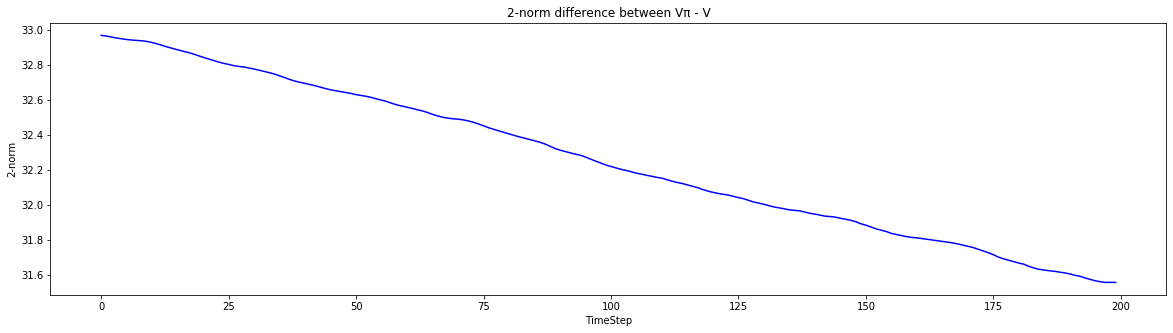

Value Function:  [0.96841043 0.51654248 0.09183889 0.43977553 0.42295997 0.
 0.59714015 0.77312738 0.39077704 0.33254236]
Explored States Count:   defaultdict(<class 'int'>, {1: 23, 7: 35, 0: 48, 8: 16, 9: 13, 3: 19, 4: 18, 6: 25, 2: 3})
Minimum Delta:   31.555159734433744

With Diminishing Step Size
MDP with 10 states and 2 actions
discounting factor gamma = 0.95, step size alpha = 0.01

Running  500 episodes

The Policy is (state,action) = probability
(0,0) = 0.4835164835164835  (0,1) = 0.5164835164835165  
(1,0) = 0.48854961832061067  (1,1) = 0.5114503816793893  
(2,0) = 0.881578947368421  (2,1) = 0.11842105263157894  
(3,0) = 0.7980769230769231  (3,1) = 0.20192307692307693  
(4,0) = 0.2926829268292683  (4,1) = 0.7073170731707317  
(5,0) = 0.4430379746835443  (5,1) = 0.5569620253164557  
(6,0) = 0.88  (6,1) = 0.12  
(7,0) = 0.4715447154471545  (7,1) = 0.5284552845528455  
(8,0) = 0.30952380952380953  (8,1) = 0.6904761904761905  
(9,0) = 0.34328358208955223  (9,1) = 0.656716417910447

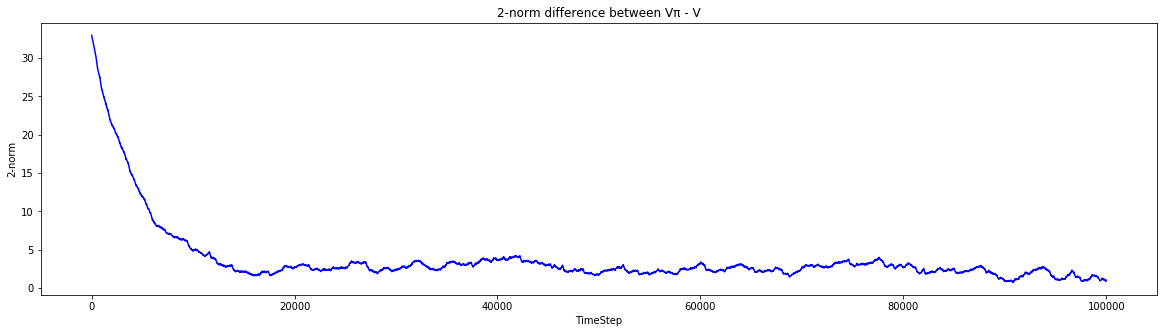

Value Function:  [10.20839251  9.81289878 10.14271575 10.19098998 10.09747938  9.97268904
 10.33724025 10.1814383  10.23186408 10.09418846]
Explored States Count:   defaultdict(<class 'int'>, {0: 6938, 2: 10263, 5: 21414, 3: 9347, 1: 8670, 8: 8617, 7: 10516, 4: 7396, 9: 7169, 6: 9670})
Minimum Delta:   0.749415718633464


In [6]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import mdptoolbox.example
import random


class n_StepTDLearner:
    """
    Class that will ues on policy temporal difference
    prediction to solve the model free problem with a given policy

    """

    def __init__(self, policy, states, actions, alpha=0.01, gamma=0.95, beta = 0.5, diminish = None, episodes = 1000, timesteps = 200,n_step = 5):
        #action value function, mapping each state action pair
        #initialized to have 0 for every new state action pair
        self.value_function = np.zeros(states)

        #step size between [0,1]
        self.alpha = alpha
        self.gamma = gamma

        #the mapping of states to actions
        self.policy = policy

        #the amount of states and actions
        self.states = states
        self.actions = actions
        #state space S
        self.state_space = np.arange(0,self.states)
        #action space A
        self.action_space = np.arange(0,self.actions)

        #transition probability matrix P, with shape AxSxS'
        self.transitionProbabilities, self.rewardMatrix = mdptoolbox.example.rand(states,actions)
        
        #the reward matrix
        self.rewardMatrix = np.random.rand(actions,states,states)

        #transition probability matrix under policy pi
        self.probabilityMatrix = np.zeros((self.states,self.states))
        
        #only for diminishing step size using alpha and beta
        self.diminish = diminish
        self.step_size = self.alpha
        self.beta = beta
        
        #amount of episodes to run the environment for
        self.episodes = episodes
        #max time steps in an episode
        self.T = timesteps
        
        #keeps track of the amount of times the states have been visited
        self.exploringStates = defaultdict(int)
        
        #estimated v_pi, using value iteration
        self.v_pi = [10.3269891,10.28997413, 10.61215495, 10.47182536, 10.53804012, 10.44741659, 10.58984017, 10.28781177, 10.42280426, 10.27326007]
        
        #save the difference between v_pi and v
        self.difference= []
        
        #n step trajecrtory you would like to 
        self.n = n_step
        
        
    def setVpi(self,v_pi):
        """
        Set the estimated v_pi to what you found
        Must be called before running the environment
        Default reward matrix is set to what was found in value iteration
        
        For this to work
        :param v_pi: estimated v_pi, needs to be in length of state space S
        :returns: void
        """
        self.v_pi = v_pi  
        
    
    def setRewardMatrix(self,matrix):
        """
        Change the reward matrix to whatever you want with this function
        Must be called before running the environment
        Default reward matrix is set to random values between [0,1]
        
        For this to work
        Matrix needs to be in shape AxSxS
        A is the Action space
        S is the State space
        
        :param matrix: the reward matrix of choice
        :return: void
        """
        self.rewardMatrix = matrix
        
    def createProbabilityMatrix(self):
        
        #to run TD, the transition probability matrix has to be under the policy 
        #taking the sum of the probabilities of taking that action a under state s and multiplying that by the transition probability value 
        
        for s in range(self.states):
            probabilities = np.zeros(self.states)
            for a in range(self.actions):
                    action_prob = self.policy[s][a]
                    probabilities += self.transitionProbabilities[a][s]*action_prob
            self.probabilityMatrix[s] = probabilities
            

    def getNextState(self, state, action):
        """
        Just return the next state based on the transition probability matrix and the action taken
        Using random choice that will use a distribution to give a state
        :param state: observation that was previously seen
        :param action: action that was take
        :return: next state that the agent will go to 
        """
            
        next_state = np.random.choice(self.state_space,1,p = self.probabilityMatrix[state])
        return next_state[0]


        
    def chooseAction(self, state):
        """
        Using the current state and the given policy find the action  using random choice based on the probabilities
        :param state: the current state the agent is at
        :return: the action to be taken
        """
        
        p = []
        for action,prob in sorted(self.policy[state].items()):
            p.append(prob)
            
        action = np.random.choice(self.action_space, 1, p = p)
        
        return action[0] 



    def takeAction(self,state):
        """
        Perform the action on the environment and see the observation
        :return: next state S' , reward R
        state sucessor and the reward observed
        """
        
        action = self.chooseAction(state)
        next_state = self.getNextState(state,action)
        reward = self.rewardMatrix[action][state][next_state]
        
        return next_state,reward
    
    
    def TDupdate(self):
        """
        Need to use episodes because otherwise it doesn't explore since my ploicy is not e-greedy
        Using the puesdo-code in Sutton and Barto doing the n-step TD Bootstrapping to predict Vπ
        
        the V(S) function update is
        Vt+n(St) = Vt+n−1(St) + α[Gt:t+n − Vt+n−1(St)]
        """
    
        
        states = []
        rewards = [0]
        
        #starting initial state
        state = np.random.randint(0,self.states)
        states.append(state)
        
        #timestep
        t = 0
        while True:
            
            if t<self.T:
                next_state,reward = self.takeAction(state)
                states.append(next_state)
                self.exploringStates[next_state]+=1
                rewards.append(reward)
            tau = t-self.n+1
            if tau>=0:
                G = 0
                #find the total discounted expected reward
                G = sum([(self.gamma**(i-tau-1))*rewards[i] for i in range(tau+1,min(tau+self.n+1,self.T+1))])
                if tau+self.n < self.T:
                    G += (self.gamma**self.n) * self.value_function[states[tau+self.n]]
                    
                #update the value function
                self.value_function[states[tau]] += self.step_size*(G - self.value_function[states[tau]])
        
                #find the difference between v_pi and v and save it
                self.difference.append(np.linalg.norm(self.v_pi-self.value_function))
                
            if tau==self.T-1:
                break
                
            t+=1
    
    

        
        
        
    def runEnvironment(self):
        """
        Will run the OpenGym AI environment set using on policy Temporal Difference Learning
        :return: the difference in case needed for debugging
        
        Rough Estimate of the Value Function Limit
        [10.3269891,10.28997413, 10.61215495, 10.47182536, 10.53804012, 10.44741659, 10.58984017, 10.28781177, 10.42280426, 10.27326007]
        """
    
        #create the transition probability matrix given the policy pi
        self.createProbabilityMatrix()
        
        
        #each episode perform the update
        for i_episode in range(self.episodes):
            self.TDupdate()
        
        return self.difference 
            
    
        
    def plot(self):
        
        """
        For debugging and checking
        Provide Information on the Agent and MDP
        Plot the 2-norm difference between v_pi and v
        """
        
        #info on the MDP
        print(f"MDP with {self.states} states and {self.actions} actions\ndiscounting factor gamma = {self.gamma}, step size alpha = {self.step_size}\n")
        print("Running ", self.episodes, "episodes")
        
        #info on the policy
        print("\nThe Policy is (state,action) = probability")
        for s in range(self.states):
            for a in range(self.actions):
                print(f"({s},{a}) = {self.policy[s][a]} ",end=" ")
            print()
                      
    
        #plot of 2-norm difference between v_pi and v
        plt.figure(figsize=(20,5))
        plt.plot(range(len(self.difference)), self.difference, 'b-')
        plt.title("2-norm difference between Vπ - V")
        plt.xlabel("TimeStep")
        plt.ylabel("2-norm")
        plt.show()
        
        #info on the value function and explored states
        print("Value Function: ", self.value_function)
        print("Explored States Count:  ", self.exploringStates)
        print("Minimum Delta:  ", min(self.difference))


if __name__ == '__main__':
    
    
    """
    The Main Function to Run your program
    Example code given below
    All hyperparameters can be adjusted to your liking
    
    
    Policy must be given  
    the policy will be in the format of 
    (state,action) = Probability
    
    in python code it will be a dictionary inside of a dictionary
    {state: {action: probability of that action, action: probabiity, ... } state:{...}}
    """

    
    
    policy = {0: {0: 0.4835164835164835, 1: 0.5164835164835165}, 1: {0: 0.48854961832061067, 1: 0.5114503816793893}, 2: {0: 0.881578947368421, 1: 0.11842105263157894}, 3: {0: 0.7980769230769231, 1: 0.20192307692307693}, 4: {0: 0.2926829268292683, 1: 0.7073170731707317}, 5: {0: 0.4430379746835443, 1: 0.5569620253164557}, 6: {0: 0.88, 1: 0.12}, 7: {0: 0.4715447154471545, 1: 0.5284552845528455}, 8: {0: 0.30952380952380953, 1: 0.6904761904761905}, 9: {0: 0.34328358208955223, 1: 0.6567164179104478}}
    
    states = 10
    actions = 2

    
    np.random.seed(0)

    print("With Constant Step Size")
    learner = n_StepTDLearner(policy = policy,states = states, actions = actions,episodes = 1)
    learner.runEnvironment()
    learner.plot()
    
    
    print("\nWith Diminishing Step Size")
    learner = n_StepTDLearner(policy = policy,states = states, actions = actions,episodes = 500 , diminish = lambda a,k,b: a/(k**b))
    learner.runEnvironment()
    learner.plot()
    
    
    
    
    
    #running multiple n-Step together
    plots  = []
    policy = {0: {0: 0.4835164835164835, 1: 0.5164835164835165}, 1: {0: 0.48854961832061067, 1: 0.5114503816793893}, 2: {0: 0.881578947368421, 1: 0.11842105263157894}, 3: {0: 0.7980769230769231, 1: 0.20192307692307693}, 4: {0: 0.2926829268292683, 1: 0.7073170731707317}, 5: {0: 0.4430379746835443, 1: 0.5569620253164557}, 6: {0: 0.88, 1: 0.12}, 7: {0: 0.4715447154471545, 1: 0.5284552845528455}, 8: {0: 0.30952380952380953, 1: 0.6904761904761905}, 9: {0: 0.34328358208955223, 1: 0.6567164179104478}}

    plt.figure(figsize = (15,5))
    for n in range(0,8):
        plots = []
        #for i in range(100):
        learner = n_StepTDLearner(policy = policy,states = 10, actions = 2,episodes = 250, n_step = 2**n)
        graph = learner.runEnvironment()
        plots.append(graph)
        print("n =", 2**n)
        plt.plot(range(len(graph)), np.average(plots,axis = 0), label = f"n = {2**n}")
        print("Minimum Delta:  ", min(graph),"\n\n")
    plt.title("On-Policy n-step TD",fontsize = 20)
    plt.xlabel("iteration",fontsize = 20)
    plt.ylabel("2-norm of Vπ - V",fontsize = 20)
    plt.legend(fontsize = 14)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.show()




n = 1
Minimum Delta:   5.054256643016609 


n = 2
Minimum Delta:   2.975517804108837 


n = 4
Minimum Delta:   2.230518687704541 


n = 8
Minimum Delta:   6.681171417172359 


n = 16
Minimum Delta:   1.7213337778024718 


n = 32
Minimum Delta:   1.600173383509411 


n = 64
Minimum Delta:   3.1824124500482758 


n = 128
Minimum Delta:   2.0034228733908104 




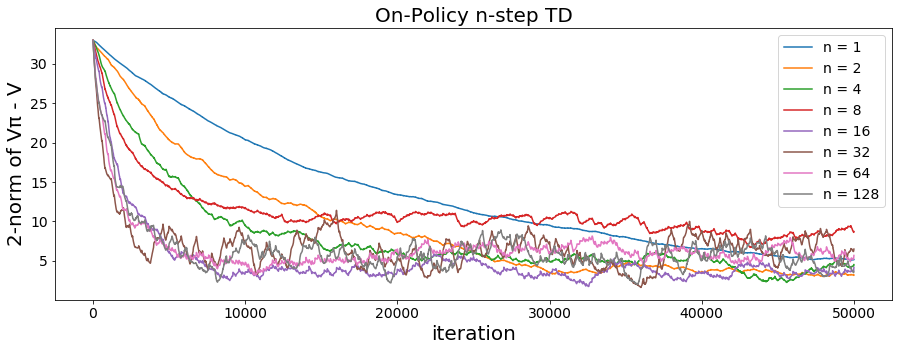